In [1]:
import tensorflow as tf
import pandas as pd
import multiprocessing
import concurrent.futures
from PIL import Image
import numpy as np
from tensorflow.keras.utils import Sequence, to_categorical
from tensorflow.keras.applications.densenet import DenseNet201
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPool2D, BatchNormalization, Dropout, GlobalAveragePooling2D, Activation
from keras.applications import DenseNet201
from keras.models import Model
from keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Input

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report

In [2]:
image_size=224
def resize_image_array(image_path):
    return np.asarray(Image.open(image_path).resize((image_size,image_size)))
def get_images(df_paths):
    max_workers = multiprocessing.cpu_count()
    with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
        image_arrays = list(executor.map(resize_image_array, ('ISIC_2019/train/' + df_paths['image'] + '.jpg').tolist()))
    return np.array(image_arrays)

In [3]:
def load_data(x_df_path, y_df_path):
    x_df = pd.read_csv(x_df_path)
    y_df = pd.read_csv(y_df_path)
    x_paths = x_df.iloc[:, 0:1]
    x_meta = x_df.iloc[:,1:].values
    y = y_df.iloc[:,:].values
    x_img = get_images(x_paths)
    x_img = np.array(x_img)
    x_img = x_img / 255
    return x_img, x_meta, y

In [4]:
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam

def build_densenet201():
    base_model = DenseNet201(weights='imagenet',
                             include_top=False,
                             input_tensor=Input(shape=(224, 224, 3))
                            )
    
    for layer in base_model.layers:
        layer.trainable = True
    
    x = GlobalAveragePooling2D()(base_model.output)
    
    x = Dense(512)(x)
    x = Dropout(0.2)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Dense(128)(x)
    x = Dropout(0.2)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Dense(52)(x)
    x = Dropout(0.2)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Dense(16)(x)
    x = Dropout(0.2)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Dense(8, activation='sigmoid')(x)
    
    model = Model(inputs=base_model.input, outputs=x)
    
    optimizer = Adam(learning_rate=0.0001)
    
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [5]:
import tensorflow as tf

class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(position, d_model)

    def get_angles(self, position, i, d_model):
        angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
        return position * angles

    def positional_encoding(self, position, d_model):
        angle_rads = self.get_angles(
            position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
            i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
            d_model=d_model,
        )
        sines = tf.math.sin(angle_rads[:, 0::2])
        cosines = tf.math.cos(angle_rads[:, 1::2])

        pos_encoding = tf.concat([sines, cosines], axis=-1)
        pos_encoding = pos_encoding[tf.newaxis, ...]
        return tf.cast(pos_encoding, tf.float32)

    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, dropout=0.1):
        super(TransformerBlock, self).__init__()
        self.att = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential(
            [tf.keras.layers.Dense(ff_dim, activation="relu"), tf.keras.layers.Dense(embed_dim),]
        )
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = tf.keras.layers.Dropout(dropout)
        self.dropout2 = tf.keras.layers.Dropout(dropout)

    def call(self, inputs):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output)
        out1 = self.layernorm1(inputs + attn_output)

        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output)
        return self.layernorm2(out1 + ffn_output)

class TFormer(tf.keras.Model):
    def __init__(self, embed_dim=128, num_heads=8, ff_dim=128, num_transformer_blocks=6, mlp_units=128, dropout=0.1, mlp_dropout=0.1):
        super(TFormer, self).__init__()

        self.embedding = tf.keras.layers.Embedding(input_dim=11, output_dim=embed_dim)
        self.positional_encoding = PositionalEncoding(11, embed_dim)

        self.transformer_blocks = [TransformerBlock(embed_dim, num_heads, ff_dim, dropout) for _ in range(num_transformer_blocks)]

        self.flatten = tf.keras.layers.Flatten()
        self.mlp = tf.keras.Sequential(
            [
                tf.keras.layers.Dense(mlp_units, activation=tf.nn.gelu),
                tf.keras.layers.Dropout(mlp_dropout),
                tf.keras.layers.Dense(8, activation="sigmoid"),
            ]
        )

    def call(self, inputs):
        x = self.embedding(inputs)
        x += self.positional_encoding(x)
        
        for transformer_block in self.transformer_blocks:
            x = transformer_block(x)
        
        x = self.flatten(x)
        return self.mlp(x)

In [6]:
def build_complex_dnn(input_dim):
    model = tf.keras.Sequential()

    # Capa de entrada
    model.add(tf.keras.layers.InputLayer(input_shape=(input_dim,)))

    # Capas ocultas
    model.add(tf.keras.layers.Dense(512, activation='relu'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dropout(0.5))

    model.add(tf.keras.layers.Dense(256, activation='relu'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dropout(0.5))

    model.add(tf.keras.layers.Dense(128, activation='relu'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dropout(0.5))

    model.add(tf.keras.layers.Dense(64, activation='relu'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dropout(0.5))

    # Capa de salida
    model.add(tf.keras.layers.Dense(8, activation='sigmoid'))

    return model

def build_combined_model():
    # Crear la red CNN
    cnn_model = build_densenet201()

    # Crear la red Transformer
    transformer_model = TFormer()
    transformer_model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )

    # Obtener las salidas de ambas redes
    cnn_output = cnn_model.output
    transformer_output = transformer_model.output

    # Concatenar las salidas de ambas redes
    concatenated_output = tf.keras.layers.Concatenate()([cnn_output, transformer_output])

    # Crear la DNN compleja que toma la salida concatenada como entrada
    dnn_model = build_complex_dnn(input_dim=concatenated_output.shape[-1].value)

    # Conectar la salida de la DNN a la entrada de la red final
    final_output = dnn_model(concatenated_output)

    # Crear el modelo combinado
    combined_model = tf.keras.Model(inputs=[cnn_model.input, transformer_model.input], outputs=final_output)

    # Compilar el modelo combinado
    combined_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return combined_model

In [7]:
from tensorflow.keras.layers import Input, Dense, concatenate

def build_combined_model(densenet_model, tformer_model):
    # Crear capas de entrada separadas para DenseNet y TFormer
    densenet_input = densenet_model.input
    tformer_input = Input(shape=(10,))  # Ajusta la forma de entrada según tus metadatos

    # Obtener las salidas directas de DenseNet y TFormer
    densenet_output = densenet_model.output
    tformer_output = tformer_model(tformer_input)

    # Concatenar las salidas de ambos modelos
    combined_output = concatenate([densenet_output, tformer_output])

    # Agregar capas Dense (totalmente conectadas) para la red neuronal densa
    dense_layer1 = Dense(512, activation='relu')(combined_output)
    dense_layer1 = BatchNormalization()(dense_layer1)
    dense_layer1 = Dropout(0.5)(dense_layer1)
    
    dense_layer2 = Dense(256, activation='relu')(dense_layer1)
    dense_layer2 = BatchNormalization()(dense_layer2)
    dense_layer2 = Dropout(0.5)(dense_layer2)
    
    dense_layer3 = Dense(128, activation='relu')(dense_layer2)
    dense_layer3 = BatchNormalization()(dense_layer3)
    dense_layer3 = Dropout(0.5)(dense_layer3)
    
    dense_layer4 = Dense(64, activation='relu')(dense_layer3)
    dense_layer4 = BatchNormalization()(dense_layer4)
    dense_layer4 = Dropout(0.5)(dense_layer4)

    # Agregar capa de salida
    output_layer = Dense(8, activation='sigmoid')(dense_layer4)

    # Crear el modelo combinado con dos entradas y una salida
    combined_model = Model(inputs=[densenet_input, tformer_input], outputs=output_layer)

    # Compilar el modelo combinado con el mismo optimizador, función de pérdida y métricas
    combined_model.compile(optimizer=Adam(learning_rate=0.0001),
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])

    return combined_model

In [8]:
def plot_confusion_matrix(y_true, y_pred, diseases, cmap=plt.cm.Blues):
    ConfusionMatrixDisplay.from_predictions(y_pred=y_pred, y_true=y_true, cmap=cmap)
    plt.xticks(np.arange(len(diseases)), diseases, rotation=45)
    plt.yticks(np.arange(len(diseases)), diseases)
    plt.grid(False)
    plt.show()

def plot_normalized_confusion_matrix(y_true, y_pred, diseases):
    cm = confusion_matrix(y_true, y_pred)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    cm_df = pd.DataFrame(cm_normalized, index=diseases, columns=diseases)
    sns.heatmap(cm_df, annot=True, cmap='Blues', fmt=".2f", cbar=True)
    plt.xticks(np.arange(len(diseases)) + 0.5, diseases, rotation=45)
    plt.yticks(np.arange(len(diseases)) + 0.5, diseases, rotation=0)
    plt.gca().set_facecolor('lightgray')
    plt.gca().add_patch(plt.Rectangle((0, 0), len(diseases), len(diseases), fill=False, edgecolor='black', lw=2))
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

def plot_classification_report(y_true, y_pred, diseases):
    print(classification_report(y_pred=y_pred, y_true=y_true, target_names=diseases))

def print_multiclass_cm_metrics(y_true, y_pred, diseases, printable = False, plottable=True):
    mcm = multilabel_confusion_matrix(y_true=y_true, y_pred=y_pred)
    accuracy = []
    sensitivity = []
    specificity = []
    precision = []
    
    for i in range(len(mcm)):
        tp = mcm[i][1,1]
        tn = mcm[i][0,0]
        fp = mcm[i][0,1]
        fn = mcm[i][1,0]
        current_accuracy = (tp+tn)/(tp+tn+fp+fn)
        current_sensitivity = (tp)/(tp+fn)
        current_specificity = (tn)/(tn+fp)
        current_precision = (tp)/(tp+fp)
        if printable:
            print(f"\tPrecision: {current_precision}")
            print(f"\tSensitivity: {current_sensitivity}")
            print(f"\tSpecificity: {current_specificity}")
            print(f"\tAccuracy: {current_accuracy}")
            print()
        accuracy.append(current_accuracy)
        precision.append(current_precision)
        sensitivity.append(current_sensitivity)
        specificity.append(current_specificity)
    
    width = 0.3
    x = np.arange(len(diseases))
    font_size=6
    if plottable:
        plt.bar(x-width,precision, width = width, label='Precision')
        plt.bar(x, accuracy, width=width, label='Accuracy')
        plt.bar(x+width, sensitivity, width=width, label='Sensitivity')
        for x1, x2, x3, y1, y2, y3 in zip(x-width, x, x+width, precision, accuracy, sensitivity):
            plt.text(x1, y1, '%.2f' % y1, ha='center', va='bottom', fontsize=font_size)
            plt.text(x2, y2, '%.2f' % y2, ha='center', va='bottom', fontsize=font_size)
            plt.text(x3, y3, '%.2f' % y3, ha='center', va='bottom', fontsize=font_size)
        plt.xticks(x, diseases)
        plt.legend(loc='lower left')
        plt.show()

def get_metrics(x_test, y_test, model):
    diseases = ['MEL', 'NV', 'BCC', 'AK', 'BKL', 'DF', 'VASC', 'SCC']
    y_pred = model.predict(x_test)
    y_pred = np.argmax(y_pred, axis=1)
    y_true =  np.argmax(y_test, axis=1)
    plot_confusion_matrix(y_true=y_true, y_pred=y_pred, diseases=diseases)
    plot_normalized_confusion_matrix(y_true=y_true, y_pred=y_pred, diseases=diseases)
    plot_classification_report(y_pred=y_pred, y_true=y_true, diseases=diseases)
    print_multiclass_cm_metrics(y_true=y_true, y_pred=y_pred, diseases=diseases)

In [9]:
X_train_img, X_train_meta, y_train = load_data('X_train_df.csv', 'y_train_df.csv')
X_val_img, X_val_meta, y_val = load_data('X_val_df.csv', 'y_val_df.csv')
X_test_img, X_test_meta, y_test = load_data('X_test_df.csv', 'y_test_df.csv')

In [10]:
class MultiInputDataGenerator(Sequence):
    def __init__(self, cnn_x_set, transformer_x_set, y_set, batch_size):
        self.cnn_x, self.transformer_x, self.y = cnn_x_set, transformer_x_set, y_set
        self.batch_size = batch_size
        self.indexes = np.arange(len(self.cnn_x))

    def __len__(self):
        return int(np.ceil(len(self.cnn_x) / self.batch_size))

    def __getitem__(self, idx):
        start = idx * self.batch_size
        end = (idx + 1) * self.batch_size

        batch_cnn_x = self.cnn_x[start:end]
        batch_transformer_x = self.transformer_x[start:end]
        batch_y = self.y[start:end]

        return [batch_cnn_x, batch_transformer_x], batch_y


In [11]:
def convert_numpy_to_tensor(X_train):
    X_train_tensor = tf.convert_to_tensor(X_train)
    return X_train_tensor

In [12]:
X_train_meta = convert_numpy_to_tensor(X_train_meta[:,:])
y_train_meta = convert_numpy_to_tensor(y_train)
X_val_meta = convert_numpy_to_tensor(X_val_meta[:,:])
y_val_meta = convert_numpy_to_tensor(y_val)
X_test_meta = convert_numpy_to_tensor(X_test_meta[:,:])
y_test_meta = convert_numpy_to_tensor(y_test)

In [13]:
X_train_meta.shape

TensorShape([8800, 10])

In [14]:
batch_size = 8
train_gen = MultiInputDataGenerator(X_train_img, X_train_meta, y_train, batch_size)
val_gen = MultiInputDataGenerator(X_val_img, X_val_meta, y_val, batch_size)
test_gen = MultiInputDataGenerator(X_test_img, X_test_meta, y_test, batch_size)

In [15]:
densenet_model = build_densenet201()
tformer_model = TFormer()
tformer_model.compile(optimizer=Adam(learning_rate=0.0001),
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])

In [16]:
combined_model = build_combined_model(densenet_model, tformer_model)

In [17]:
combined_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                            

In [18]:
history = combined_model.fit(train_gen, validation_data=val_gen, epochs=30)

Epoch 1/30
1100/1100 [==============================] - 313s 258ms/step - loss: 2.9228 - accuracy: 0.1634 - val_loss: 2.1811 - val_accuracy: 0.1455
Epoch 2/30
1100/1100 [==============================] - 282s 257ms/step - loss: 2.2801 - accuracy: 0.2686 - val_loss: 1.5070 - val_accuracy: 0.5873
Epoch 3/30
1100/1100 [==============================] - 278s 253ms/step - loss: 1.9167 - accuracy: 0.3747 - val_loss: 1.3407 - val_accuracy: 0.6136
Epoch 4/30
1100/1100 [==============================] - 278s 252ms/step - loss: 1.7068 - accuracy: 0.4540 - val_loss: 1.3084 - val_accuracy: 0.6136
Epoch 5/30
1100/1100 [==============================] - 278s 252ms/step - loss: 1.5561 - accuracy: 0.5170 - val_loss: 1.3157 - val_accuracy: 0.6136
Epoch 6/30
1100/1100 [==============================] - 278s 252ms/step - loss: 1.4852 - accuracy: 0.5427 - val_loss: 1.2534 - val_accuracy: 0.6136
Epoch 7/30
1100/1100 [==============================] - 278s 252ms/step - loss: 1.4386 - accuracy: 0.5625 - val_

In [19]:
results = combined_model.evaluate(test_gen)
print("Loss:", results[0])
print("Accuracy:", results[1])

138/138 [==============================] - 11s 78ms/step - loss: 1.2523 - accuracy: 0.6091
Loss: 1.252349853515625
Accuracy: 0.6090909242630005


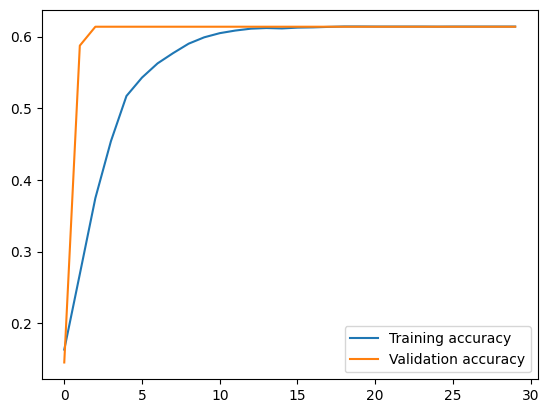

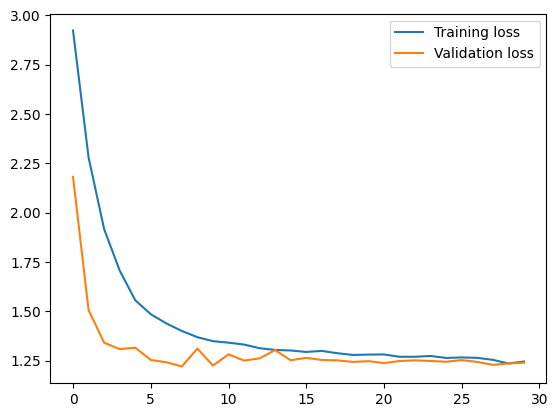

In [20]:
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.show()

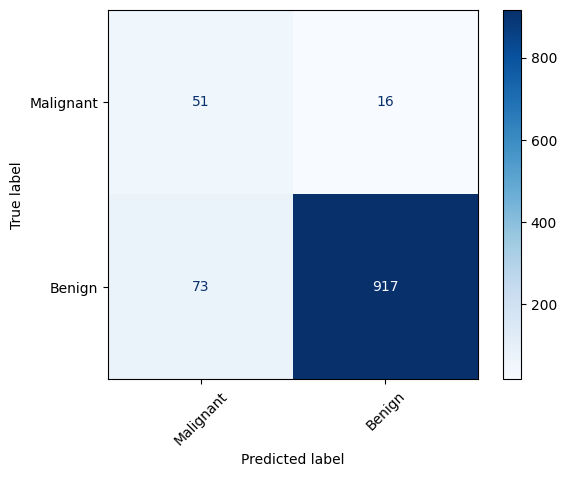

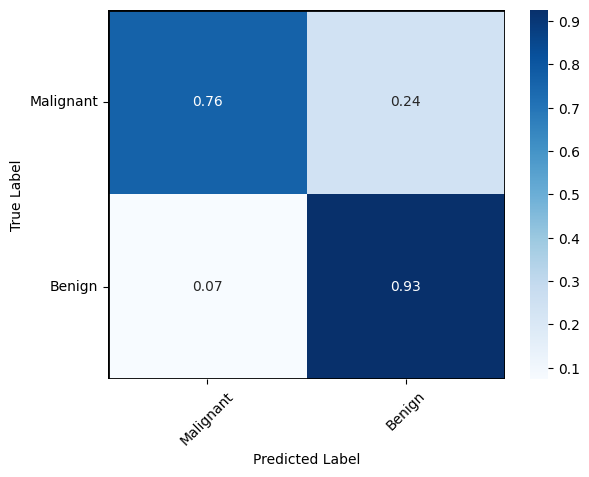

              precision    recall  f1-score   support

   Malignant       0.41      0.76      0.53        67
      Benign       0.98      0.93      0.95       990

    accuracy                           0.92      1057
   macro avg       0.70      0.84      0.74      1057
weighted avg       0.95      0.92      0.93      1057



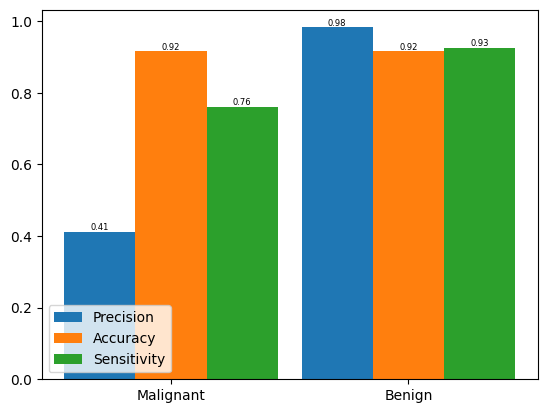

In [2]:
get_metrics(X_test_img, y_test, densenet_model)

In [22]:
combined_model.save_weights('combined_model_weights_1.h5')